# MODELO CNN PARA CLASIFICACION DE FRUTAS

###  <span style="color:BLUE">1: IMPORTAMOS LIBRERIAS QUE SON IMPORTANTES PARA EL DESARROLLO DEL MODELO


In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import datasets, layers, models
from PIL import Image, ImageChops, ImageEnhance, ImageOps
from os import listdir, mkdir
from os.path import isfile, join
from sklearn import svm, model_selection, datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
%matplotlib notebook
from tensorflow.keras.models import load_model
import matplotlib.image as mpimg
import imageio as im
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from time import time

###  <span style="color:BLUE">2: CARGAMOS EL DATASET Y DEFINIMOS PARAMETROS DE ENTRENAMIENTO

In [30]:
# dimensión de las imágenes
img_width, img_height = 100,100

#ruta de las imágenes de MANZANAS
#train_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/trainManzanas'
#validation_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/testManzanas'
#img_path = 'C:/Users/XAVIEERBBC/Desktop/dataset/testManzanas/freshapples/resized_rotated_by_15_Screen Shot 2018-06-08 at 4.59.49 PM.png'

#---------------------------------------------------------------------------------------------

#ruta de las imágenes de NARANJAS
#train_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/TrainNaranjas'
#validation_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/TestNaranjas'
#img_path = 'C:/Users/XAVIEERBBC/Desktop/dataset/TestNaranjas/freshoranges/resized_rotated_by_15_Screen Shot 2018-06-12 at 11.50.41 PM.png'
#----------------------------------------------------------------------------------------------

#ruta de las imágenes de PLATANOS
#train_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/TrainPlatanos/'
#validation_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/TestPlatanos/'
#img_path = 'C:/Users/XAVIEERBBC/Desktop/dataset/TestPlatanos/freshbanana/resized_rotated_by_15_Screen Shot 2018-06-12 at 9.38.04 PM.png'

#----------------------------------------------------------------------------------------/''-------

'''ruta de las imágenes de TODAS LAS FRUTAS'''
train_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/TrainAll'
validation_data_dir = 'C:/Users/XAVIEERBBC/Desktop/dataset/TestAll'
img_path = 'C:/Users/XAVIEERBBC/Desktop/dataset/testManzanas/freshapples/resized_rotated_by_15_Screen Shot 2018-06-08 at 4.59.49 PM.png'

#-----------------------------------------------------------------------------------------------

nb_train_samples = 4000
nb_validation_samples = 800

'''DEFINIMOS LOS EPOCHS Y EL BARCH SIZE'''
epochs = 40
batch_size = 256

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

###  <span style="color:BLUE">3: GUARDAMOS LAS IMAGENES CON UN NUEVO TAMAÑO


In [31]:
# ESTO ES PARA SALVAR LAS IMÁGENES CON LAS NUEVAS DIMENSIONES
#ruta = "dataset/train"
#newdir = "resizeImages"
#mkdir(newdir)

#def ls(ruta):
#    return [arch for arch in listdir(ruta) if isfile(join(ruta, arch))]

#def resized(origen, destino,ancho,largo):
    
#    for name in ls(origen):

        #print (name)
        #imagen = Image.open(origen+"/"+name)
        #new_image = imagen.resize((ancho, largo))
        #new_image.save(destino+"/"+"resized_"+name)

In [32]:
def roc_auc_score(y_pred, y_true):
    pos = tf.boolean_mask(y_pred, K.cast(y_true, tf.bool))
    neg = tf.boolean_mask(y_pred, ~K.cast(y_true, tf.bool))
    pos = K.expand_dims(pos, 0)
    neg = K.expand_dims(neg, 1)
    
    gamma = 0.2
    p     = 3
    difference = K.zeros_like(pos * neg) + pos - neg - gamma
    masked = tf.boolean_mask(difference, difference < 0.0)
    return K.sum(K.pow(-masked, p))

###  <span style="color:BLUE">4: CREAMOS UNA ESTRUCTURA INICIAL DEL MODELO


In [33]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)       

###  <span style="color:BLUE">5: ESTABLECEMOS LA ESTRUCTURA DE COMPILACION


In [34]:
#Compilación

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

#Creación del DataSET a partir de las imágenes en la carpeta dataset

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#REESCALADO

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Conjunto de datos y etiquetas para ENTRENAMIENTO
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Conjunto de datos y etiquetas para VALIDACIÓN
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


###  <span style="color:BLUE">6: REALIZAMOS EL ENTRENAMIENTO DEL MODELO


In [36]:
epochs_to_wait_for_improve = 2

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=epochs_to_wait_for_improve)

checkpoint_callback = ModelCheckpoint('early.h5', 
                                      monitor='val_loss', 
                                      verbose=1, 
                                      save_best_only=True, 
                                      mode='min')


#Entrenamiento
start_time = time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping_callback, checkpoint_callback])


# Salvado de pesos como archivo
model.save_weights( 'lala'+'.h5')

elapsed_time = time() - start_time

Epoch 1/40
14/15 [===========================>..] - ETA: 1s - loss: -24.2916 - accuracy: 0.1415
Epoch 00001: val_loss improved from inf to -24.21773, saving model to early.h5
15/15 [==============================] - 30s 2s/step - loss: -24.2637 - accuracy: 0.1441 - val_loss: -24.2177 - val_accuracy: 0.1302
Epoch 2/40
14/15 [===========================>..] - ETA: 1s - loss: -24.8695 - accuracy: 0.1476
Epoch 00002: val_loss did not improve from -24.21773
15/15 [==============================] - 30s 2s/step - loss: -24.9804 - accuracy: 0.1474 - val_loss: -24.2177 - val_accuracy: 0.1302
Epoch 3/40
14/15 [===========================>..] - ETA: 1s - loss: -24.6513 - accuracy: 0.1451
Epoch 00003: val_loss did not improve from -24.21773
15/15 [==============================] - 32s 2s/step - loss: -24.6769 - accuracy: 0.1445 - val_loss: -24.2177 - val_accuracy: 0.1302


In [37]:
print(elapsed_time)

92.0351836681366


###  <span style="color:BLUE">7: PRESENTAMOS LA CAPTURA DE LOS RESULTADOS 


<IPython.core.display.Javascript object>


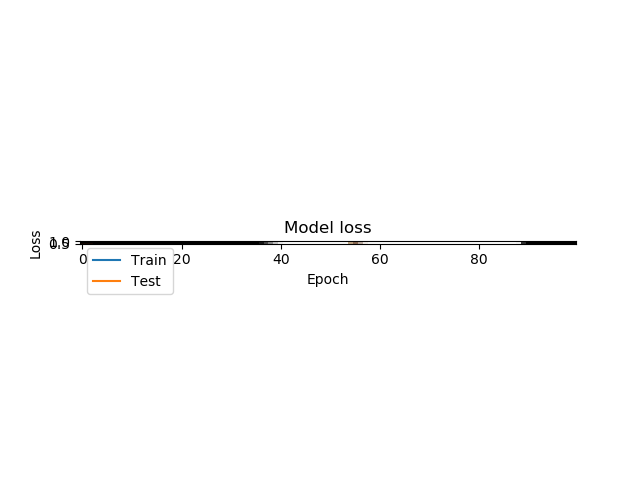

43/43 - 68s - loss: -2.4641e+01 - accuracy: 0.1450


In [38]:
#Curva aciertos en épocas 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

evaluation = model.evaluate_generator(train_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=2)


In [39]:
# Plot ENTRENAMIENTO & VALIDACI accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot ENTRENAMIENTO & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
#img_path = 'dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 4.59.49 PM.png'

img = image.load_img(img_path, target_size=(100, 100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

(1, 100, 100, 3)


###  <span style="color:BLUE">8: MAPEO DE LAS CARACTERISTICAS DE LA IMAGEN CARGADA
</span>

In [41]:
image = np.expand_dims(image, axis=0) #para agregar una dimensión extra

In [42]:
layer_outputs = [layer.output for layer in model.layers[:5]] # Extrae los resultados de las 5 capas superiores.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Crea un modelo que devolverá las salidas, dada la entrada del modelo

In [43]:
activations = activation_model.predict(img_tensor) # Devuelve una lista de cinco matrices

<IPython.core.display.Javascript object>


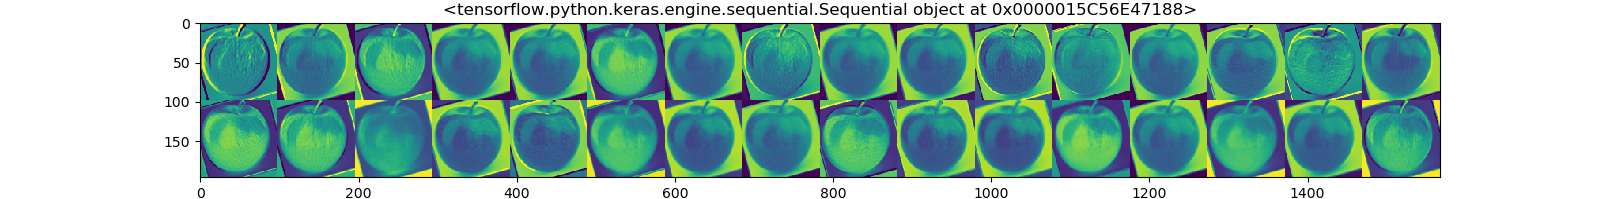

C:\Users\XAVIEERBBC\anaconda3\envs\AmbienteRedesNeuronales\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


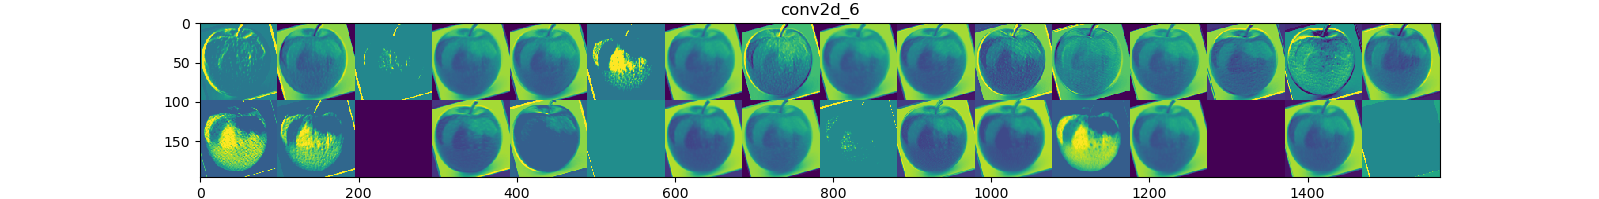

<IPython.core.display.Javascript object>


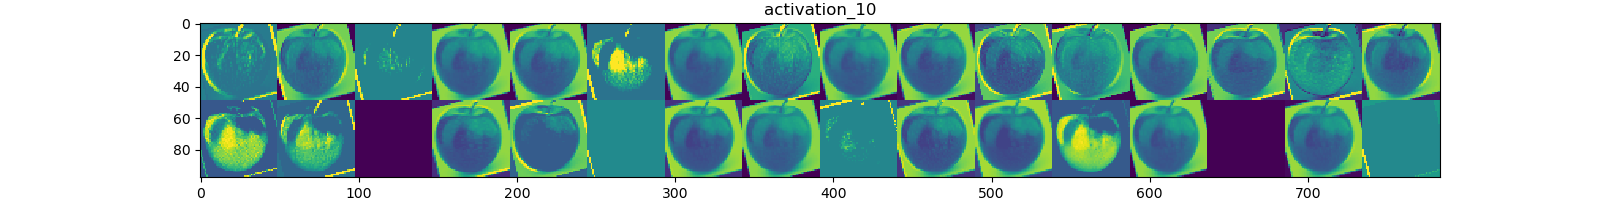

<IPython.core.display.Javascript object>


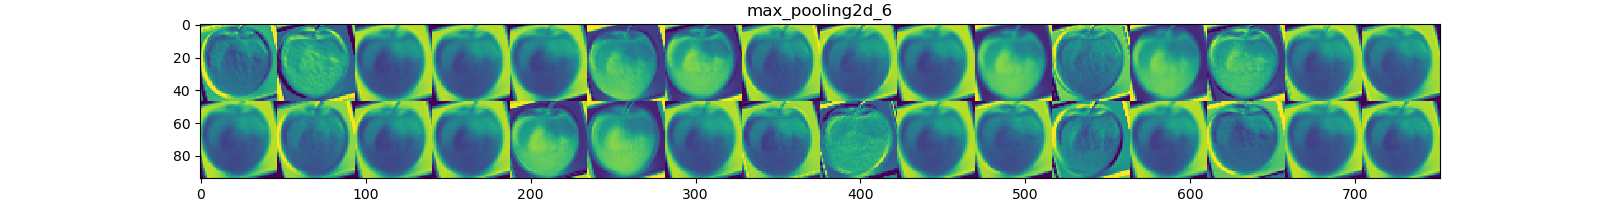

<IPython.core.display.Javascript object>


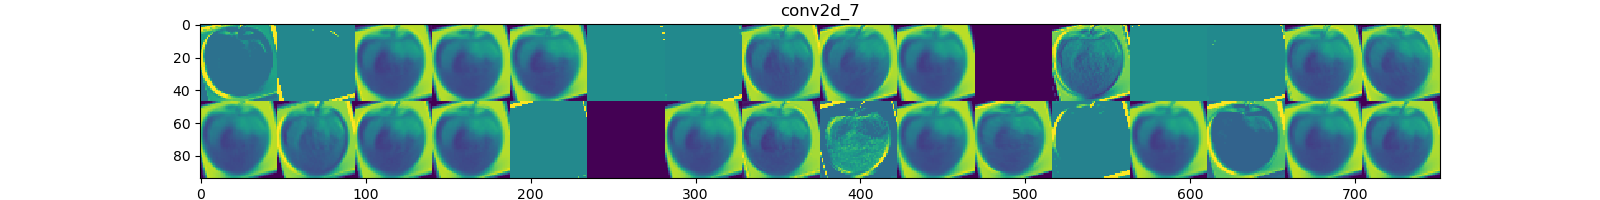

In [44]:
layer_names = [model]
for layer in model.layers[:12]:
    layer_names.append(layer.name) # nombre de las capas
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Muestra los mapas de características
    n_features = layer_activation.shape[-1] # Número de características en el mapa de características
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row # Mosaicos de los canales de activación en esta matriz
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): #Coloca cada filtro en una cuadrícula horizontal
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-procesa la función para que sea visualmente agradable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')